In [ ]:
symbols = [s.strip() for s in open('symbols.txt')]
names = [s.strip('\\') for s in symbols]

tex2im = 'tex2im-1.8/tex2im'
for code in symbols:
    name = code.strip('\\')
    if name.islower() and name.title() in names:
        name += '_lower'
    if name.istitle() and name.lower() in names:
        name += '_upper'
    print name
    fname = 'symbols/%s.png' % name
    get_ipython().getoutput("%s -o %s \"%s\"" % (tex2im, fname, code.replace('\\','\\\\')))

# Load images

In [559]:
import skimage.io
from glob import glob

images = {}
for fname in glob('symbols/*.png'):
    name = fname.split('/')[-1].split('.')[0].split('_')[0]
    images[name] = skimage.io.imread(fname, flatten=True)

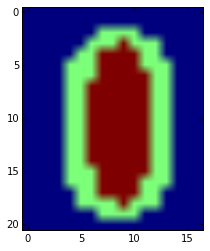

In [560]:
imshow(skimage.measure.label(images['0']))

# Extract parts with context


In [561]:
import skimage.measure
import skimage.transform

def first(arr):
    return next(i for i,v in enumerate(arr.flat) if v)
def last(arr):
    return -next(i for i,v in enumerate(arr[::-1].flat) if v)  
def get_parts(img, mask = None):
    if mask == None:
        mask = img
    label_im = skimage.measure.label(mask)
    labels = set(label_im.flatten())
    all_parts = ( (1-img)*(label_im==i) for i in labels )
    good_parts = ( p for p in all_parts if any(p) )
    buff = max(img.shape)
    padded = np.pad(1-img, buff, mode='minimum')
    for p in good_parts:
        hor, ver = p.sum(axis=0), p.sum(axis=1)
        t,l,b,r = first(ver), first(hor), last(ver), last(hor)
#         img_parts_pos[name][i] = (t,l,b,r)
#         img_parts[name][i] = p[t:b,l:r]
        h,w = img.shape
        h,w = h-t+b, w-l+r
#         yield padded[t+h/2:b-h+h/2, l+w/2:r-w+w/2]
        scale = 16.0/max(h,w)
#         print scale,
        off = 2*scale
        pad = padded[buff+t-w/2-off:b+w/2-buff+off, buff+l-h/2-off:r+h/2-buff+off]
        yield skimage.transform.resize(pad, (40,40))

img_parts = {}
for name, img in images.items():
#     print name
    img_parts[name] = dict(enumerate( get_parts(img) ))

(40, 40)

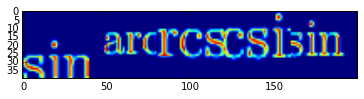

In [562]:
imshow(hstack([p for p in img_parts['arcsin'].values()]))
img_parts['arcsin'][1].shape

# Train classifier

In [563]:
data = [(p.flatten(), (name+'-%s'%i)) for name, parts in img_parts.items() for i,p in parts.items()]
X,y = zip(*data)

In [564]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [565]:
lr.score(X,y)

0.96363636363636362

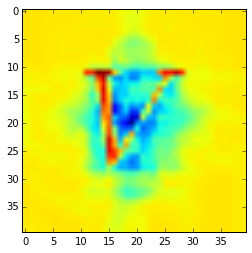

In [566]:
imshow(lr.coef_[54].reshape(40,40))

# Score new components

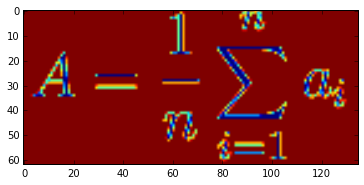

In [567]:
example = skimage.io.imread('example.png', flatten=True)
imshow(example)

15


(40, 40)

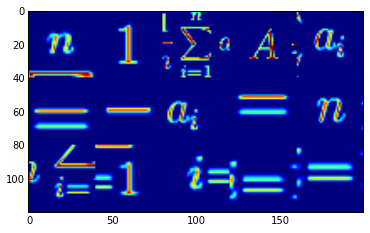

In [576]:
parts = list(get_parts(example))
print len(parts)
imshow(vstack([hstack(parts[:5]), hstack(parts[5:10]), hstack(parts[10:15])]))
parts[0].shape

In [569]:
lr.predict(vstack(p.flatten() for p in parts))

array(['equiv-0', '1-0', 'Sigma-0', 'A-0', 'Phi-0', '=-0', '--0',
       'arcsin-4', '=-1', 'n-0', '=-1', 'Upsilon-0', 'bullet-0', 'cosh-0',
       '=-1'], 
      dtype='|S17')

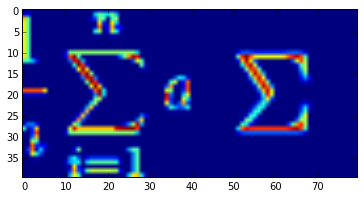

In [570]:
imshow(hstack([parts[2], img_parts['Sigma'][0]]))

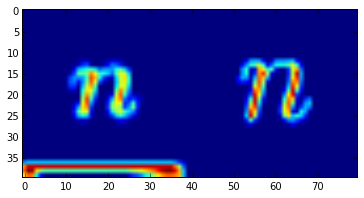

In [598]:
imshow(hstack([parts[0], img_parts['n'][0]]))

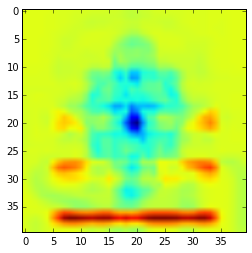

In [599]:
class2id = {v:k for k,v in enumerate(lr.classes_)}
imshow(lr.coef_[class2id['equiv-0']].reshape((40,40)))

In [593]:
from collections import Counter

Counter(dict(zip(lr.classes_,lr.predict_proba(parts[0].flatten()).flat))).most_common(10)

[('equiv-0', 0.29271236671628265),
 ('bullet-0', 0.093337381931654376),
 ('n-0', 0.058118352189765819),
 ('u-0', 0.017316513442238439),
 ('a-0', 0.012729788899847102),
 ('mu-0', 0.012495464664513123),
 ('ast-0', 0.010378684056212808),
 ('kappa-0', 0.010314278417738373),
 ('theta-0', 0.0093088271176103334),
 ('h-0', 0.0085508087895101604)]